In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import json
import scipy.stats as stats
import nltk
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

plt.style.use('ggplot')

%matplotlib inline
plt.rc('figure', figsize=(10,8))
plt.rc('patch', force_edgecolor=True, ec='black', lw=1.2)
# plt.rcdefaults()

What kind of recipes, in terms of nutritions, are represented in the dataset? Overall picture of the data.

Explore trends/pattern, relationships between nutritional data. E.g. Calories relationship to fat, carb, protein, etc....
Official figures: 4 calories/gram of carb, 4 per gram/protein, 9 calories/gram of fat

Looking at the baseline 2000 calories diet, what do the data reveal about the types of recipes scraped from Epicurious in terms of nutritional values? In other words, how do the different nutritions compare in content? Fat, carb, protein in relation to the recommended for a 2000 calories diet. 

What types of recipes, in terms of major ingredients, tend to be more relatively "healthy" based on caloric and macro nutrient values?

Various statistics: Ingredient counts, categories/tags counts, directions and description word counts. Ratings vs. main ingredients. Nutritions vs. main ingredients.

Correlation between various counts. e.g. length of description/direction against ingredient counts.

Compare different notable categories: vegetarian, vegan, meat

Quick & easy category and description of recipes: 45 minutes or less. **Found identical descriptions from examining most frequently used words**

Recipes with and without description?

In [2]:
recipes = pd.read_pickle('recipes.pkl')
recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18277 entries, 0 to 18276
Data columns (total 12 columns):
calories       18277 non-null int64
carb           18277 non-null int64
categories     18277 non-null object
date           18277 non-null datetime64[ns]
desc           13655 non-null object
directions     18277 non-null object
fat            18277 non-null int64
ingredients    18277 non-null object
protein        18277 non-null int64
rating         18277 non-null float64
sodium         18277 non-null int64
title          18277 non-null object
dtypes: datetime64[ns](1), float64(1), int64(5), object(5)
memory usage: 1.7+ MB


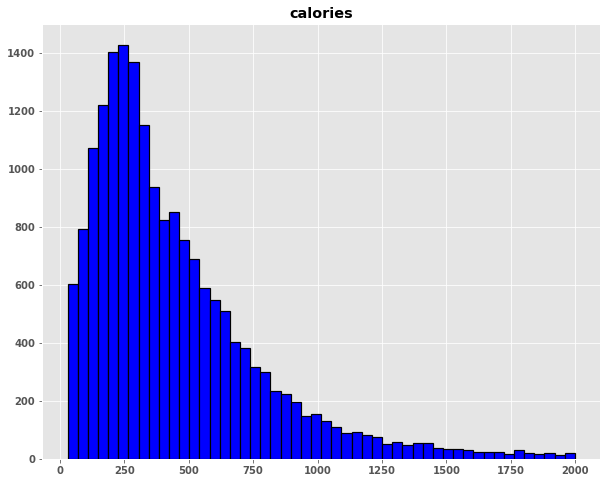

In [4]:
_ = recipes.hist('calories', bins=50, color = 'b')

In [6]:
recipes.head()

,calories,carb,categories,date,desc,directions,fat,ingredients,protein,rating,sodium,title
0,426,77,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",2006-09-01 04:00:00,None,"[1. Place the stock, lentils, celery, carrot, ...",7,"[4 cups low-sodium vegetable or chicken stock,...",30,2.500,559,"Lentil, Apple, and Turkey Wrap"
1,403,34,"[Food Processor, Onion, Pork, Bake, Bastille D...",2004-08-20 04:00:00,This uses the same ingredients found in boudin...,[Combine first 9 ingredients in heavy medium s...,23,"[1 1/2 cups whipping cream, 2 medium onions, c...",18,4.375,1439,Boudin Blanc Terrine with Red Onion Confit
2,357,92,"[Candy, Citrus, Quick & Easy, Low Sodium, Grap...",2004-08-20 12:48:48,None,[Quarter the grapefruits lengthwise and remove...,0,"[3 large grapefruits, 13 cups cold water, 4 cu...",1,5.000,17,Candied Grapefruit Zest
3,691,21,"[Leafy Green, Shellfish, Marinate, Sauté, High...",2004-08-20 04:00:00,When Roy Yamaguchi invited me to cook at the 5...,"[Preheat oven to 350°F., Dip each crab in milk...",41,"[8 soft shell crabs, cleaned (See note), 1 cup...",57,3.750,1533,Soft-Shell Crabs with Wilted Spinach and Warm ...
4,181,39,"[Sauce, Fruit, Ginger, Dessert, Low Sodium, Wh...",2004-08-20 04:00:00,A simple dessert sauce that is absolutely deli...,"[Combine Sauternes, sugar, water and whole clo...",1,[1/2 cup plus 2 tablespoons Sauternes or Late ...,1,5.000,11,Kumquat Compote with Sauternes and Ginger


In [12]:
# 13,655 out of 18,277 recipes contain description
descriptions = recipes.loc[~recipes.desc.isnull()]

# Copying recipes to make necessary modifications: concats, cleaning, etc....
recipes_mod = recipes.copy()

# Concatenating recipe title with description
recipes_mod.desc.fillna('', inplace=True)
recipes_mod['desc_mod'] = recipes_mod.title + ' ' + recipes_mod.desc
recipes_mod['desc_mod'] = recipes_mod.desc_mod.str.strip()

In [11]:
def get_top(text_corp, top_n = 20, **kwargs_vect):
    
    # Get the top_n most common words (or n_grams) from a corpus
    vect = CountVectorizer(**kwargs_vect)
        
    freq_mat = vect.fit_transform(text_corp)
    counts = np.array(freq_mat.sum(axis=0)).flatten()
    
    freqs = [(w, counts[ind]) for w, ind in vect.vocabulary_.items()]
    freqs.sort(key=lambda x: x[1], reverse=True)
    
    return freqs[:top_n]

    
def get_counts_dist(text_corp, bins = 10, plot = False, **kwargs_vect):
    
    vect = CountVectorizer(**kwargs_vect)
        
    count_mat = vect.fit_transform(text_corp)
    wc = np.array(count_mat.sum(axis=1)).flatten()
    
    if plot:
        plt.hist(wc, bins = bins)

    return pd.Series(wc).describe(), wc

(count    13655.000000
 mean        30.832589
 std         25.653103
 min          1.000000
 25%         13.000000
 50%         24.000000
 75%         40.000000
 max        307.000000
 dtype: float64, array([19, 89, 17, ..., 27, 44, 81], dtype=int64))

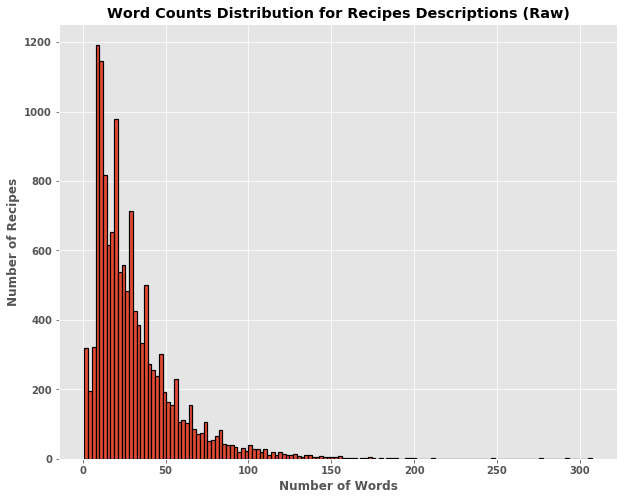

In [7]:
# Distribution of word counts in descriptions for recipes with a description. Before cleaning and concatenating.
desc_stats = get_counts_dist(descriptions.desc, bins='auto', plot = True)
_ = plt.title('Word Counts Distribution for Recipes Descriptions (Raw)')
_ = plt.xlabel('Number of Words')
_ = plt.ylabel('Number of Recipes')
desc_stats

(count    18277.000000
 mean        28.223067
 std         25.998253
 min          1.000000
 25%          8.000000
 50%         21.000000
 75%         39.000000
 max        308.000000
 dtype: float64, array([ 5, 26,  3, ..., 31, 53, 84], dtype=int64))

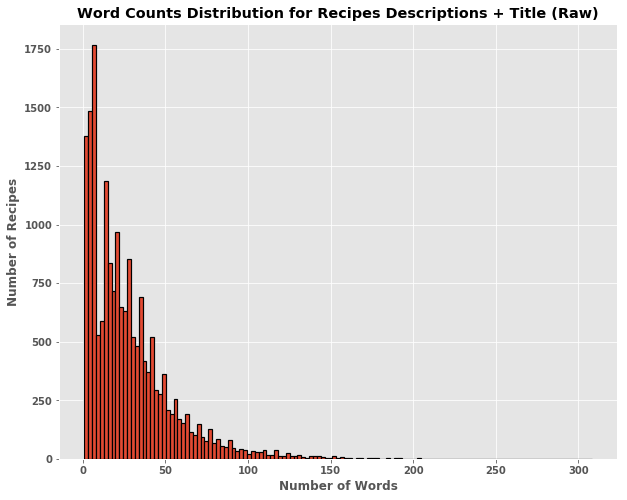

In [8]:
# After concatenating description and title
desc_stats2 = get_counts_dist(recipes_mod.desc_mod, bins='auto', plot = True)
_ = plt.title('Word Counts Distribution for Recipes Descriptions + Title (Raw)')
_ = plt.xlabel('Number of Words')
_ = plt.ylabel('Number of Recipes')
desc_stats2

In [98]:
# Top most frequently used words in recipes descriptions

# top_100 = get_top(recipes_mod.desc_mod, 100, (1,1))

# We see some potential recipe/food specific stopwords to add to our lists
# top_100

(count    18277.00000
 mean       149.72501
 std         98.82470
 min          1.00000
 25%         83.00000
 50%        127.00000
 75%        192.00000
 max       1237.00000
 dtype: float64, array([145, 241, 235, ...,  71, 137, 311], dtype=int64))

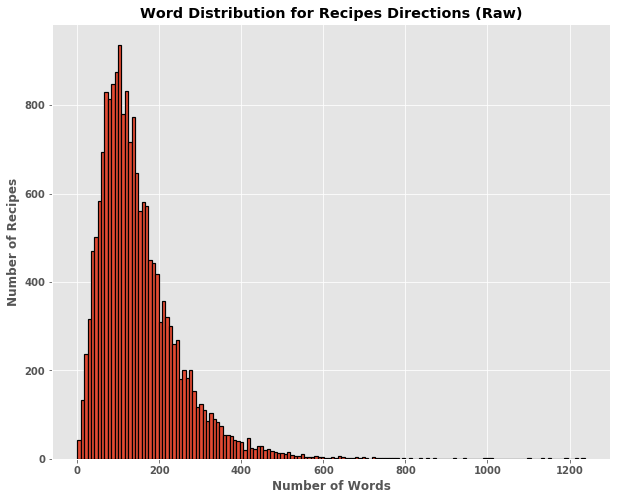

In [92]:
# Distribution of word counts in directions for recipes. Before cleaning.

def list_prep(text_list, sep= ' '):
    return sep.join(e for e in text_list).lower()

dir_stats = get_counts_dist(recipes.directions, bins='auto', plot = True, preprocessor=list_prep)
_ = plt.title('Word Distribution for Recipes Directions (Raw)')
_ = plt.xlabel('Number of Words')
_ = plt.ylabel('Number of Recipes')
dir_stats

(count    18277.000000
 mean        10.406084
 std          4.508740
 min          1.000000
 25%          7.000000
 50%         10.000000
 75%         13.000000
 max         41.000000
 dtype: float64, array([15, 28,  4, ...,  5,  7, 16], dtype=int64))

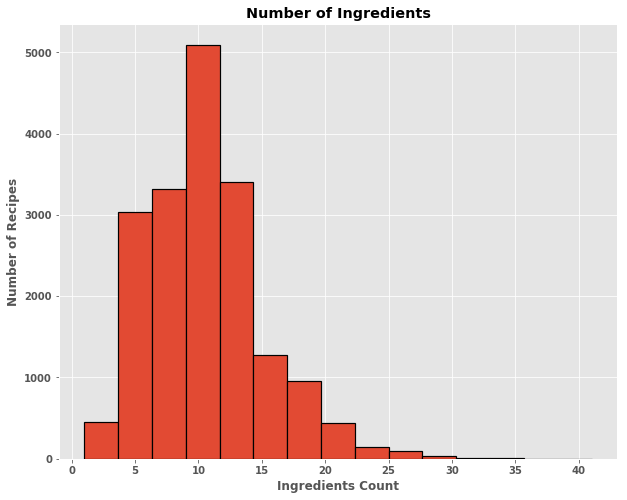

In [15]:
# Distribution of number of ingredients
def dummy(text): # Dummy funct. to use our lists with CountVectorizer
    return text

ingr_stats = get_counts_dist(recipes.ingredients, bins=15, plot=True,  preprocessor=dummy, tokenizer=dummy)
_ = plt.title('Number of Ingredients')
_ = plt.xlabel('Ingredients Count')
_ = plt.ylabel('Number of Recipes')
ingr_stats

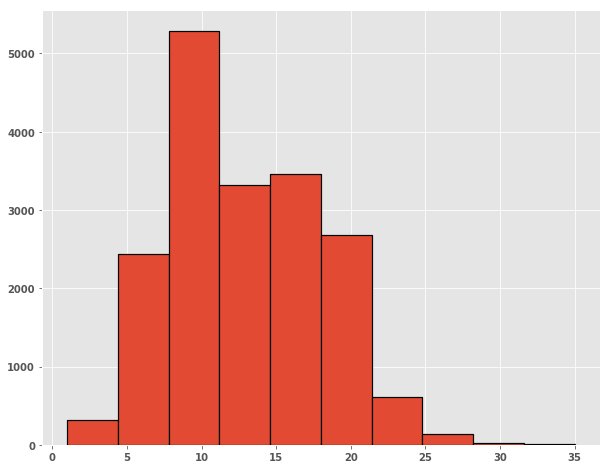

In [16]:
# Distribution of number of categories
cat_stats = get_counts_dist(recipes.categories, bins=10, plot=True, preprocessor=dummy, tokenizer=dummy)

In [16]:
# Counting frequency of categories.

# all_cats = []
# [all_cats.extend(cat) for cat in recipes.categories]
# categories = pd.Series(all_cats)
# cat_freq = categories.value_counts()

# _ = plt.hist(categories.value_counts(),bins=30)
# cat_freq.describe()

In [15]:
# cat_freq
# recipes.categories.loc[6338]

In [23]:
# Recipes without a description

# rnd = recipes[recipes.desc.isnull()]

In [19]:
# get_top(descriptions.categories, preprocessor=dummy,tokenizer=dummy)

In [20]:
# get_top(rnd.categories, prep=dummy,tok=dummy)

In [21]:
get_counts_dist(descriptions.title)

(count    13655.000000
 mean         5.207909
 std          2.198991
 min          1.000000
 25%          3.000000
 50%          5.000000
 75%          7.000000
 max         19.000000
 dtype: float64, array([ 7, 11,  6, ...,  4,  9,  3], dtype=int64))

In [24]:
# rnd.describe()
get_counts_dist(rnd.title)

(count    4622.000000
 mean        5.127650
 std         2.237794
 min         1.000000
 25%         3.000000
 50%         5.000000
 75%         7.000000
 max        16.000000
 dtype: float64, array([5, 3, 7, ..., 2, 8, 2], dtype=int64))

In [69]:
counts_dist(recipes.title)

(count    18277.000000
 mean         5.187613
 std          2.209082
 min          1.000000
 25%          3.000000
 50%          5.000000
 75%          7.000000
 max         19.000000
 dtype: float64, array([5, 7, 3, ..., 4, 9, 3], dtype=int64))

In [17]:
recipes_mod.head()

,calories,carb,categories,date,desc,directions,fat,ingredients,protein,rating,sodium,title,desc_mod
0,426,77,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",2006-09-01 04:00:00,,"[1. Place the stock, lentils, celery, carrot, ...",7,"[4 cups low-sodium vegetable or chicken stock,...",30,2.500,559,"Lentil, Apple, and Turkey Wrap","Lentil, Apple, and Turkey Wrap"
1,403,34,"[Food Processor, Onion, Pork, Bake, Bastille D...",2004-08-20 04:00:00,This uses the same ingredients found in boudin...,[Combine first 9 ingredients in heavy medium s...,23,"[1 1/2 cups whipping cream, 2 medium onions, c...",18,4.375,1439,Boudin Blanc Terrine with Red Onion Confit,Boudin Blanc Terrine with Red Onion Confit Thi...
2,357,92,"[Candy, Citrus, Quick & Easy, Low Sodium, Grap...",2004-08-20 12:48:48,,[Quarter the grapefruits lengthwise and remove...,0,"[3 large grapefruits, 13 cups cold water, 4 cu...",1,5.000,17,Candied Grapefruit Zest,Candied Grapefruit Zest
3,691,21,"[Leafy Green, Shellfish, Marinate, Sauté, High...",2004-08-20 04:00:00,When Roy Yamaguchi invited me to cook at the 5...,"[Preheat oven to 350°F., Dip each crab in milk...",41,"[8 soft shell crabs, cleaned (See note), 1 cup...",57,3.750,1533,Soft-Shell Crabs with Wilted Spinach and Warm ...,Soft-Shell Crabs with Wilted Spinach and Warm ...
4,181,39,"[Sauce, Fruit, Ginger, Dessert, Low Sodium, Wh...",2004-08-20 04:00:00,A simple dessert sauce that is absolutely deli...,"[Combine Sauternes, sugar, water and whole clo...",1,[1/2 cup plus 2 tablespoons Sauternes or Late ...,1,5.000,11,Kumquat Compote with Sauternes and Ginger,Kumquat Compote with Sauternes and Ginger A si...


In [357]:
# Looking at common occurrences of numeric values found in descriptions

In [26]:
# num_pat = re.compile(r'(?<!^)(?:\b\d+.*?\s[^\d\W]+\b)')

In [1035]:
# get_top(recipes_mod.directions, 50, token_pattern=num_pat, preprocessor=list_prep)

In [1034]:
# get_top(recipes_mod.desc_mod, 50, token_pattern=num_pat)

In [18]:
#Stop words, adding recipes specific words to sklearn and nltk's builtin lists
from sklearn.feature_extraction import stop_words

sw = set(stop_words.ENGLISH_STOP_WORDS)
sw.update(nltk.corpus.stopwords.words('english'))

# Some Recipe/Food specific stopwords
rf_sw = ['ingredient', 'food', 'recipe', 'step', 'direction', 'flavor', 'make', 'meal', 'epicurious']
sw.update(rf_sw)
sw.remove('whole')

In [19]:
from nltk.stem import WordNetLemmatizer
from unidecode import unidecode

In [56]:
t = '* Apricot Almond Shortbread* Shells** 4* {This} [recipe] was (created) to prepare <epi:recipeLink ="14264">Apricot Almond Shortbreads</epi:recipeLink>.<P> You will need three mini-muffin pans, each 2/3/1999 twelve 1 3/4-by-1 inch cups.'
re.sub('<.*?>|[\[\](){}]', '', t)
re.sub(re.compile(r'<.*?>|[*\[\](){}]'), '', t)

'* Apricot Almond Shortbread* Shells** 4* {This} [recipe] was (created) to prepare <epi:recipeLink ="14264">Apricot Almond Shortbreads</epi:recipeLink>.<P> You will need three mini-muffin pans, each 2/3/1999 twelve 1 3/4-by-1 inch cups.'

In [108]:
def preprocess(texts, tok_pat, tokenize=True):
    """
    Preprocess/Clean text columns of recipes.
    
    """
    #Check if input is just a string then turn into list of 1 str.
    if isinstance(texts, str):
        texts = [texts]
    
    wnl = WordNetLemmatizer()
    regex = re.compile(tok_pat)
    cleaned = []
    
    for t in texts:
        text = t.lower()
        text = re.sub('<.*?>|[*\[\](){}]', '', text) # clean up stray html tags, remove brackets
        text = ' '.join(wnl.lemmatize(unidecode(word)) for word in text.split())
        tokens = regex.findall(text)

        cleaned.append('*'.join(t for t in tokens if t not in sw and len(t) > 2))
        
    return cleaned

In [65]:
# Pattern for tokenization. Match individual words or digits along with the following word

tok_pat = re.compile(r'[^\d\W][\w-]+|\d+.*?(?:(?=[.;:]\s|,\s[^\d\W])|\s[^\d\W]+)')

In [109]:
# Preprocess description column and keeping as separate col.
# recipes_mod['desc_mod_clean'] = recipes_mod.desc_mod.apply(lambda e: preprocess(e,tok_pat)[0])

In [110]:
# Preprocess directions column, slightly modified to ignore step numbers.
tp_dir = re.compile(r'[^\d\W][\w-]+|(?<!^)\d+.*?(?:(?=[.;:]\s|,\s[^\d\W])|\s[^\d\W]+)')

# recipes_mod['dir_clean'] = recipes_mod.directions.apply(preprocess, tok_pat=tp_dir)

In [111]:
# Preprocess ingredients

# recipes_mod['ingr_clean'] = recipes_mod.ingredients.apply(preprocess, tok_pat=tok_pat)

In [293]:
# ([i for e in recipes_mod.categories for i in e if re.search('[^\w\s]',i)])
# [i for i in recipes_mod.desc_mod_clean if '*' in i]

In [286]:
# Clean categories
recipes_mod['cat_clean'] = [[unidecode(i).lower() for i in e] for e in recipes_mod.categories]

# Join categories for each recipe into one string
cat_join = pd.Series('*'.join(i for i in e) for e in recipes_mod.cat_clean)
# cat_join

# Directions join
dir_join = pd.Series('*'.join(i for i in e) for e in recipes_mod.dir_clean)

# Ingredients join
ingr_join = pd.Series('*'.join(i for i in e) for e in recipes_mod.ingr_clean)

# Concatenating all text columns
recipes_mod['all_text'] = recipes_mod.desc_mod_clean + '*' + cat_join + '*' + dir_join + '*' + ingr_join

In [287]:
recipes_mod.head()

,calories,carb,categories,date,desc,directions,fat,ingredients,protein,rating,sodium,title,desc_mod,desc_mod_clean,dir_clean,ingr_clean,cat_clean,all_text
0,426,77,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",2006-09-01 04:00:00,,"[1. Place the stock, lentils, celery, carrot, ...",7,"[4 cups low-sodium vegetable or chicken stock,...",30,2.500,559,"Lentil, Apple, and Turkey Wrap","Lentil, Apple, and Turkey Wrap",lentil*apple*turkey*wrap,[place*stock*lentils*celery*carrot*thyme*salt*...,"[4 cup*low-sodium*vegetable*chicken*stock, 1 c...","[sandwich, bean, fruit, tomato, turkey, vegeta...",lentil*apple*turkey*wrap*sandwich*bean*fruit*t...
1,403,34,"[Food Processor, Onion, Pork, Bake, Bastille D...",2004-08-20 04:00:00,This uses the same ingredients found in boudin...,[Combine first 9 ingredients in heavy medium s...,23,"[1 1/2 cups whipping cream, 2 medium onions, c...",18,4.375,1439,Boudin Blanc Terrine with Red Onion Confit,Boudin Blanc Terrine with Red Onion Confit Thi...,boudin*blanc*terrine*red*onion*confit*boudin*b...,[combine*9 ingredient*heavy*medium*saucepan*ad...,"[1 1/2 cup*whipping*cream, 2 medium*onions*cho...","[food processor, onion, pork, bake, bastille d...",boudin*blanc*terrine*red*onion*confit*boudin*b...
2,357,92,"[Candy, Citrus, Quick & Easy, Low Sodium, Grap...",2004-08-20 12:48:48,,[Quarter the grapefruits lengthwise and remove...,0,"[3 large grapefruits, 13 cups cold water, 4 cu...",1,5.000,17,Candied Grapefruit Zest,Candied Grapefruit Zest,candied*grapefruit*zest,[quarter*grapefruit*lengthwise*remove*pulp*res...,"[3 large*grapefruit, 13 cup*cold*water, 4 cup*...","[candy, citrus, quick & easy, low sodium, grap...",candied*grapefruit*zest*candy*citrus*quick & e...
3,691,21,"[Leafy Green, Shellfish, Marinate, Sauté, High...",2004-08-20 04:00:00,When Roy Yamaguchi invited me to cook at the 5...,"[Preheat oven to 350°F., Dip each crab in milk...",41,"[8 soft shell crabs, cleaned (See note), 1 cup...",57,3.750,1533,Soft-Shell Crabs with Wilted Spinach and Warm ...,Soft-Shell Crabs with Wilted Spinach and Warm ...,soft-shell*crab*wilted*spinach*warm*tomato-bas...,"[preheat*oven*degf, dip*crab*milk*lightly*coat...","[8 soft*shell*crabs*cleaned*note, 1 cup*milk, ...","[leafy green, shellfish, marinate, saute, high...",soft-shell*crab*wilted*spinach*warm*tomato-bas...
4,181,39,"[Sauce, Fruit, Ginger, Dessert, Low Sodium, Wh...",2004-08-20 04:00:00,A simple dessert sauce that is absolutely deli...,"[Combine Sauternes, sugar, water and whole clo...",1,[1/2 cup plus 2 tablespoons Sauternes or Late ...,1,5.000,11,Kumquat Compote with Sauternes and Ginger,Kumquat Compote with Sauternes and Ginger A si...,kumquat*compote*sauterne*ginger*simple*dessert...,[combine*sauternes*sugar*water*whole*clove*hea...,[1/2 cup*plus*2 tablespoon*sauterne*late*harve...,"[sauce, fruit, ginger, dessert, low sodium, wh...",kumquat*compote*sauterne*ginger*simple*dessert...


In [294]:
# Saving modified/processed recipes data.

# recipes_mod.to_pickle('recipes_mod.pkl', protocol=pickle.HIGHEST_PROTOCOL)
# recipes_mod.to_json('recipes_mod.json', orient='split')

In [ ]:
# After cleaning
get_counts_dist(recipes_mod.desc_mod_clean, bins='auto', plot = True)

**Recommending**

In [98]:
from sklearn.metrics.pairwise import cosine_similarity

In [99]:
def calc_sims_tfidf(text_corp, **kwargs):
    
    tfidf_vect = TfidfVectorizer(**kwargs)
    tfidf_mat = tfidf_vect.fit_transform(text_corp)
    cos_sim = cosine_similarity(tfidf_mat, tfidf_mat)
    np.fill_diagonal(cos_sim, 0)
    
    return cos_sim

def recommend(recipe, sim_mat, n_recs=20):
    
    ind = recipes_mod[recipes_mod.title == recipe].index[0]
    
    top_sims = pd.Series(sim_mat[ind]).sort_values(ascending=False)
    
    recommendations = []
    for i in list(top_sims[:n_recs].index):
        recommendations.append(recipes_mod.title[i])
        
    return recommendations, top_sims[:n_recs], top_sims[:n_recs].index

In [540]:
# cs_old_desc = calc_sims_tfidf(recipes_mod.desc)
recommend('Spinach Ricotta Gnocchi with Tomato Sauce', cs_old_desc, 20)

(['Shrimp and Rice Salad',
  'Grilled Flank Steak and Red Onion with Orange Gremolata',
  'Raspberry Chocolate-Chip Pancakes',
  'Roasted Potatoes and Onions with Wilted Greens',
  'Tomato Salad with Red Onion and Herbs',
  'Pasta with Beans and Beef',
  'Paprika Rice',
  'Black Bean, Spinach, and Mushroom Burritos',
  'Shiitake Beef Stroganov',
  'Caesar Mayonnaise Dressing',
  'Sauteed Fennel, Radicchio, and Pine Nuts',
  'Apple and Blackberry Meringue Souffles',
  'Orange Whole-Wheat French Toast',
  'Beef and Mushroom Stew',
  'Cold Garlic Potato Soup',
  'Avocado Quesadillas',
  'Sauteed Red Snapper with Creamed Fennel and Onion',
  'Vegetable Stew with Couscous',
  'Steamed Rice',
  'Pasta with Sun-Dried Tomatoes, Olive, and Goat Cheese'],
 14542    1.0
 974      1.0
 293      1.0
 294      1.0
 10973    1.0
 3703     1.0
 7752     1.0
 10967    1.0
 3707     1.0
 16220    1.0
 3723     1.0
 3724     1.0
 10935    1.0
 10921    1.0
 10898    1.0
 10897    1.0
 10892    1.0
 10876

In [529]:
# recipes.loc[recipes.title == 'Spinach Ricotta Gnocchi with Tomato Sauce']
recipes_mod.loc[18174].desc

'Can be prepared in 45 minutes or less.'

In [527]:
recipes_mod.loc[14542].desc

'Can be prepared in 45 minutes or less.'

In [532]:
# Recommend using cleaned descriptions + title

# cs_clean_desc = calc_sims_tfidf(recipes_mod.desc_mod_clean) 

recommend('Spinach Ricotta Gnocchi with Tomato Sauce', cs_clean_desc, 20)

(['Spinach Gnocchi Gratin',
  "Cheat's Ricotta Gnocchi Dough",
  'Spinach Herb Sauce',
  'Gratineed Gnocchi with Spinach and Ricotta',
  'Gnocchi with Creamy Tomato-Porcini Sauce',
  'Rigatoni with Eggplant, Tomato, and Ricotta',
  'Tomato, Arugula, and Ricotta Salata Salad',
  'Pasta with Ricotta and Fresh Herbs',
  'Herb Gnocchi',
  'Sauteed Spinach',
  'Spinach Risotto',
  'Rice and Tomatoes',
  'Gnocchi with Mushrooms and Butternut Squash',
  'Sauteed Spinach and Garlic',
  'Tomato and Spinach Soup',
  'Shiitake and Ricotta Patties',
  'Mexican-Style Tomato Sauce',
  'Pasta with Roasted Eggplant, Ricotta, and Basil',
  'Spinach and Roasted Red Pepper Salad',
  'Tomato and Herb Salad'],
 9110     0.560950
 17555    0.554582
 4995     0.537185
 16731    0.512969
 8807     0.501512
 8647     0.470861
 572      0.453371
 16933    0.452226
 6495     0.443319
 476      0.442430
 6837     0.441193
 14472    0.435050
 4131     0.407583
 9624     0.402430
 8428     0.401605
 14602    0.4011

In [102]:
# cs_clean_desc_n = calc_sims_tfidf(recipes_mod.desc_mod_clean, token_pattern=tok_pat)

recommend('Spinach Ricotta Gnocchi with Tomato Sauce', cs_clean_desc_n)

(['Spinach Gnocchi Gratin',
  "Cheat's Ricotta Gnocchi Dough",
  'Spinach Herb Sauce',
  'Gratineed Gnocchi with Spinach and Ricotta',
  'Gnocchi with Creamy Tomato-Porcini Sauce',
  'Rigatoni with Eggplant, Tomato, and Ricotta',
  'Sauteed Spinach',
  'Tomato, Arugula, and Ricotta Salata Salad',
  'Pasta with Ricotta and Fresh Herbs',
  'Rice and Tomatoes',
  'Spinach Risotto',
  'Herb Gnocchi',
  'Sauteed Spinach and Garlic',
  'Mexican-Style Tomato Sauce',
  'Shiitake and Ricotta Patties',
  'Tomato and Spinach Soup',
  'Tomato and Herb Salad',
  'Gnocchi with Mushrooms and Butternut Squash',
  'Pasta with Roasted Eggplant, Ricotta, and Basil',
  'Spinach and Roasted Red Pepper Salad'],
 9110     0.555212
 17555    0.542482
 4995     0.538845
 16731    0.506686
 8807     0.501722
 8647     0.480908
 476      0.474316
 572      0.463271
 16933    0.455956
 14472    0.451038
 6837     0.449515
 6495     0.437813
 9624     0.428492
 8520     0.412585
 14602    0.404054
 8428     0.4039

In [117]:
recipes_mod.loc[recipes_mod.title == 'Spinach Herb Sauce', 'desc_mod_clean']

4995    spinach herb sauce prepared 45 minute
Name: desc_mod_clean, dtype: object

In [121]:
recipes_mod.desc_mod_clean[18174]


'spinach ricotta gnocchi tomato sauce prepared 45 minute'

In [120]:
recipes_mod.desc_mod_clean[4995]

'spinach herb sauce prepared 45 minute'

In [116]:
# Including bigrams

# cs_clean_desc_bg = calc_sims_tfidf(recipes_mod.desc_mod_clean, token_pattern=tok_pat, ngram_range=(1,2))
recommend('Spinach Ricotta Gnocchi with Tomato Sauce', cs_clean_desc_bg)

(["Cheat's Ricotta Gnocchi Dough",
  'Mexican-Style Tomato Sauce',
  'Spaghetti with Eggplant and Tomato Sauce',
  'Spinach Herb Sauce',
  'Spiced Cranberry Sauce',
  'Scallop Quenelles with Gingered Tomato Sauce',
  'Chocolate Coconut Sauce',
  'Gratineed Gnocchi with Spinach and Ricotta',
  'Spicy Cilantro Sauce',
  'Cranberry Raspberry Sauce',
  'Coconut Caramel Sauce',
  'Ginger Custard Sauce',
  'Jalapeño Garlic Sauce',
  'Apricot Caramel Sauce',
  'Sambuca Chocolate Sauce',
  'Chicken and Dumplings',
  'Mustard Watercress Sauce',
  'Rotelle with Mushroom Sauce',
  'Spicy Tomato Sauce',
  'Lemon-Pepper Dill Sauce'],
 17555    0.373182
 8520     0.342779
 7544     0.327798
 4995     0.307823
 7481     0.261232
 16706    0.256433
 16704    0.253060
 16731    0.250637
 6484     0.249570
 6365     0.245382
 17088    0.245082
 17487    0.243501
 14922    0.243001
 6559     0.242028
 8105     0.230292
 15892    0.227199
 6477     0.226597
 7059     0.224506
 353      0.223799
 11615    

In [164]:
# Using ngram_range of (1,2) seems to have yielded more recipes with 'Sauce' keyword, perhaps suggesting
# that sauces recipes are relatively uncommon (IDF upweighs 'Sauce')

# recipes_mod.loc[recipes_mod.desc_mod_clean.str.lower().str.contains('\.')]['desc_mod_clean'].index

tok_pat

re.compile(r'(?:\b[^\d\W]{2,}\b)|(?<!^)(?:\b\d+.*?\s[^\d\W]+\b)', re.UNICODE)

In [237]:
# recipes_mod.desc_mod[568]


In [248]:
from sklearn.metrics import jaccard_similarity_score as jss
from sklearn.metrics.pairwise import pairwise_kernels

In [129]:
def calc_jacc_sim(l1, l2):
    len_intersection = len(set(l1).intersection(l2))
    len_union = (len(l1) + len(l2)) - len_intersection
    return len_intersection / len_union

calc_jacc_sim(recipes_mod.categories[0], recipes_mod.categories[4])

0.03333333333333333

In [27]:
# from sklearn.metrics import pairwise_distances as pwd


# vect = TfidfVectorizer(token_pattern=tok_pat)
# mat = vect.fit_transform(recipes_mod.desc_mod_clean).todense()
# pwd(mat,mat,metric='jaccard')

In [247]:
# cs_new = calc_sims_tfidf(recipes_mod.desc_mod_clean, token_pattern=tok_pat)

# cs_new[18174,9110]

In [244]:
recommend('Spinach Ricotta Gnocchi with Tomato Sauce', cs_new)

(['Spinach Gnocchi Gratin',
  'Spinach Herb Sauce',
  "Cheat's Ricotta Gnocchi Dough",
  'Gratineed Gnocchi with Spinach and Ricotta',
  'Rigatoni with Eggplant, Tomato, and Ricotta',
  'Sauteed Spinach',
  'Tomato, Arugula, and Ricotta Salata Salad',
  'Rice and Tomatoes',
  'Pasta with Ricotta and Fresh Herbs',
  'Spinach Risotto',
  'Herb Gnocchi',
  'Sauteed Spinach and Garlic',
  'Tomato and Spinach Soup',
  'Shiitake and Ricotta Patties',
  'Gnocchi with Mushrooms and Butternut Squash',
  'Tomato and Herb Salad',
  'Cauliflower and Spinach Vinaigrette',
  'Pasta with Roasted Eggplant, Ricotta, and Basil',
  'Spinach and Roasted Red Pepper Salad',
  'Mexican-Style Tomato Sauce'],
 9110     0.555805
 4995     0.531862
 17555    0.522014
 16731    0.498280
 8647     0.482718
 476      0.474219
 572      0.464995
 14472    0.451556
 16933    0.451152
 6837     0.448804
 6495     0.435978
 9624     0.425775
 8428     0.408936
 14602    0.402747
 4131     0.402331
 427      0.399661
 4